In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.5 MB/s eta 0:00:00


Starting 5-Fold Cross-Validation (Live Re-Training)...
  Processing Fold 1/5...
  Processing Fold 2/5...
  Processing Fold 3/5...
  Processing Fold 4/5...
  Processing Fold 5/5...
Heatmap generated using rigorous 5-Fold Cross-Validation.


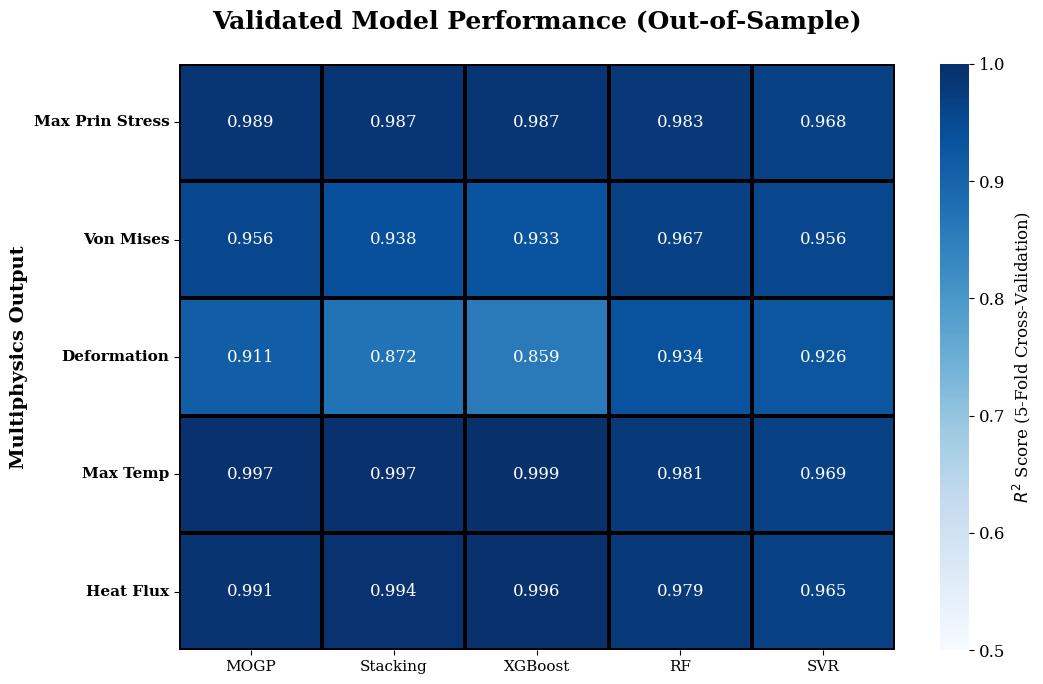

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import io
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

# --- 1. DEFINITIONS (Source of Truth: digital_twin_files.py) ---

# A. MOGP Architecture
class MOGP_Surrogate(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MOGP_Surrogate, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=6)
            ),
            num_tasks=5, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# B. Stacking Architecture
def get_fresh_stacking_model():
    estimators = [
        ('RF', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGB', XGBRegressor(objective='reg:squarederror', n_estimators=100)),
        ('SVR', SVR(kernel='rbf', C=10.0, epsilon=0.1))
    ]
    # Wrap in MultiOutput for 5 targets
    return MultiOutputRegressor(
        StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
    )

# --- 2. DATA INGESTION (N=45) ---
csv_content = """Run,Material,Power_W/mm2,Speed_mm/s,Radius_mm,Y1_Max_Prin_Stress (MPa),Y2_Max_Von_Mises,Y3_Deformation mm,Max Temp,Heat flux
1,CoCrFeNiMn ,137.27,5.31,1.44,355.95,1360.2,0.0172,255.24,0.4193
2,CoCrFeNiMn ,260.59,39.51,1.11,43.22,215.36,0.0027,58.48,0.0933
3,CoCrFeNiMn ,183.35,21.1,1.22,70.385,339.24,0.0042,79.584,0.1412
4,CoCrFeNiMn ,56.31,32.79,0.89,7.3,36.37,0.0005,28.17,0.0158
5,CoCrFeNiMn ,86.3,22.69,1.06,22.986,112.5,0.0014,41.09,0.0474
6,CoCrFeNiMn ,217.8,33.32,1.4,67.52,336.46,0.0042,78.97,0.1449
7,CoCrFeNiMn ,289.23,16.03,0.92,86.55,403.25,0.005,90.65,0.1651
8,CoCrFeNiMn ,169.14,49.17,1.27,29.557,147.42,0.0018,46.94,0.0649
9,CoCrFeNiMn ,147.07,16.71,0.94,43.89,204.7,0.0025,56.82,0.0838
10,CoCrFeNiMn ,282.05,28.76,1.29,0,0,0,22,0
11,AlCoCrFeNi,137.27,5.31,1.44,405.6,1982.7,0.031,254.83,0.4175
12,AlCoCrFeNi,260.59,39.51,1.11,57.721,310.92,0.005,58.41,0.093
13,AlCoCrFeNi,183.35,21.1,1.22,90.92,490.46,0.0078,79.47,0.1407
14,AlCoCrFeNi,56.31,32.79,0.89,9.65,51.98,0.0008,28.09,0.0156
15,AlCoCrFeNi,86.3,22.69,1.06,30.148,162.61,0.0026,41.06,0.0472
16,AlCoCrFeNi,217.8,33.32,1.4,90.2,485.68,0.0078,78.86,0.1444
17,AlCoCrFeNi,289.23,16.03,0.92,108.03,583.96,0.0092,90.52,0.1645
18,AlCoCrFeNi,169.14,49.17,1.27,39.49,212.61,0.0034,46.9,0.0646
19,AlCoCrFeNi,147.07,16.71,0.94,58.84,296.28,0.0047,56.75,0.0835
20,AlCoCrFeNi,282.05,28.76,1.29,0,0,0,22,0
21,FeCrNiTiAl,137.27,5.31,1.44,404.89,1980.9,0.0311,254.88,0.4171
22,FeCrNiTiAl,260.59,39.51,1.11,54.462,310.64,0.005,58.42,0.093
23,FeCrNiTiAl,183.35,21.1,1.22,58.788,490.1,0.0078,79.48,0.1406
24,FeCrNiTiAl,56.31,32.79,0.89,9.1938,52.51,0.0008,28.16,0.0158
25,FeCrNiTiAl,86.3,22.69,1.06,28.446,162.46,0.0026,41.06,0.0472
26,FeCrNiTiAl,217.8,33.32,1.4,85.11,485.24,0.0078,78.87,0.1444
27,FeCrNiTiAl,289.23,16.03,0.92,101.94,583.43,0.0093,90.532,0.1644
28,FeCrNiTiAl,169.14,49.17,1.27,37.258,212.41,0.0034,46.9,0.0646
29,FeCrNiTiAl,147.07,16.71,0.94,51.748,296.01,0.0047,56.76,0.0834
30,FeCrNiTiAl,282.05,28.76,1.29,0,0,0,22,0
31,NbSiTaTiZr,137.27,5.31,1.44,402.62,1985.1,0.0309,255.76,0.4206
32,NbSiTaTiZr,260.59,39.51,1.11,53.92,311.33,0.0049,58.57,0.0936
33,NbSiTaTiZr,183.35,21.1,1.22,70.41,407.24,0.0065,69.87,0.1175
34,NbSiTaTiZr,56.31,32.79,0.89,9.01,52.05,0.0008,28.12,0.0157
35,NbSiTaTiZr,86.3,22.69,1.06,24.83,134.91,0.0022,37.77,0.0326
36,NbSiTaTiZr,217.8,33.32,1.4,84.27,486.33,0.0077,79.1,0.1453
37,NbSiTaTiZr,289.23,16.03,0.92,100.84,584.51,0.0092,90.78,0.1654
38,NbSiTaTiZr,169.14,49.17,1.27,36.89,212.89,0.0034,47,0.065
39,NbSiTaTiZr,147.07,16.71,0.94,51.19,296.55,0.0047,56.88,0.0839
40,NbSiTaTiZr,282.05,28.76,1.29,0,0,0,22,0
41,HfNbTiZr,137.27,5.31,1.44,404.99,1990.7,0.0311,256.07,0.4218
42,HfNbTiZr,260.59,39.51,1.11,55.88,312.25,0.005,58.62,0.0938
43,HfNbTiZr,183.35,21.1,1.22,87.98,492.33,0.0078,79.77,0.1418
44,HfNbTiZr,56.31,32.79,0.89,9.34,52.2,0.0008,28.12,0.0157
45,HfNbTiZr,86.3,22.69,1.06,29.182,163.3,0.0026,41.165,0.0476
46,HfNbTiZr,217.8,33.32,1.4,87.193,487.08,0.0078,79.1,0.1455
47,HfNbTiZr,289.23,16.03,0.92,104.53,586.2,0.0093,90.88,0.1658
48,HfNbTiZr,169.14,49.17,1.27,38.227,213.52,0.0034,47.04,0.0652
49,HfNbTiZr,147.07,16.71,0.94,53.06,297.41,0.0047,56.93,0.0841
50,HfNbTiZr,282.05,28.76,1.29,0,0,0,22,0
"""
df = pd.read_csv(io.StringIO(csv_content))
df['Material'] = df['Material'].str.strip()
df_clean = df[(df['Y2_Max_Von_Mises'] > 1e-6) & (df['Heat flux'] > 1e-6)].copy()

# Physics Embedding
material_props = {
    'CoCrFeNiMn': [8250, 12.5, 425],
    'AlCoCrFeNi': [8000, 15.0, 445],
    'FeCrNiTiAl': [8100, 15.0, 435],
    'NbSiTaTiZr': [8350, 10.0, 405],
    'HfNbTiZr':   [8450, 8.5,  395]
}
props_df = pd.DataFrame(df_clean['Material'].map(material_props).tolist(),
                        index=df_clean.index, columns=['Density', 'Conductivity', 'Cp'])
process_params = ['Power_W/mm2', 'Speed_mm/s', 'Radius_mm']
X = pd.concat([df_clean[process_params], props_df], axis=1)
target_names = ['Y1_Max_Prin_Stress (MPa)', 'Y2_Max_Von_Mises', 'Y3_Deformation mm', 'Max Temp', 'Heat flux']
y = df_clean[target_names]

# --- 3. 5-FOLD CROSS-VALIDATION LOOP ---
print("Starting 5-Fold Cross-Validation (Live Re-Training)...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholders for OOF (Out-Of-Fold) Predictions
# Arrays of NaNs that we will fill
y_pred_stack_oof = np.full(y.shape, np.nan)
y_pred_mogp_oof = np.full(y.shape, np.nan)
y_pred_rf_oof = np.full(y.shape, np.nan)
y_pred_xgb_oof = np.full(y.shape, np.nan)
y_pred_svr_oof = np.full(y.shape, np.nan)

# Indices for re-aligning later
indices = df_clean.index.values

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"  Processing Fold {fold+1}/5...")

    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale
    X_scaler = MinMaxScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_tr_sc = X_scaler.transform(X_train)
    X_te_sc = X_scaler.transform(X_test)
    y_tr_sc = y_scaler.transform(y_train)

    # Tensors for MOGP
    tr_x_ten = torch.tensor(X_tr_sc, dtype=torch.float32)
    tr_y_ten = torch.tensor(y_tr_sc, dtype=torch.float32)
    te_x_ten = torch.tensor(X_te_sc, dtype=torch.float32)

    # --- A. TRAIN STACKING (Fresh) ---
    stack_model = get_fresh_stacking_model()
    # We use pipeline manually here to ensure scaling is respected
    stack_model.fit(X_tr_sc, y_tr_sc)

    # Predict Stack
    y_pred_sc = stack_model.predict(X_te_sc)
    y_pred_stack_oof[test_idx] = y_scaler.inverse_transform(y_pred_sc)

    # Extract Base Models from Stacking
    # stack_model is MultiOutputRegressor -> estimator is StackingRegressor
    for i in range(5): # 5 targets
        est = stack_model.estimators_[i]

        # RF
        rf_p = est.named_estimators_['RF'].predict(X_te_sc)
        y_pred_rf_oof[test_idx, i] = (rf_p * y_scaler.scale_[i]) + y_scaler.mean_[i]

        # XGB
        xgb_p = est.named_estimators_['XGB'].predict(X_te_sc)
        y_pred_xgb_oof[test_idx, i] = (xgb_p * y_scaler.scale_[i]) + y_scaler.mean_[i]

        # SVR
        svr_p = est.named_estimators_['SVR'].predict(X_te_sc)
        y_pred_svr_oof[test_idx, i] = (svr_p * y_scaler.scale_[i]) + y_scaler.mean_[i]

    # --- B. TRAIN MOGP (Fresh) ---
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
    mogp = MOGP_Surrogate(tr_x_ten, tr_y_ten, likelihood)

    mogp.train(); likelihood.train()
    optimizer = torch.optim.Adam(mogp.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, mogp)

    for _ in range(50): # 50 epochs sufficient for small data
        optimizer.zero_grad()
        out = mogp(tr_x_ten)
        loss = -mll(out, tr_y_ten)
        loss.backward()
        optimizer.step()

    mogp.eval(); likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        dist = likelihood(mogp(te_x_ten))
        mogp_p = dist.mean.numpy()
        y_pred_mogp_oof[test_idx] = y_scaler.inverse_transform(mogp_p)

# --- 4. CALCULATE VALIDATION METRICS ---
targets = ["Max Prin Stress", "Von Mises", "Deformation", "Max Temp", "Heat Flux"]
results = {
    "MOGP": [], "Stacking": [], "XGBoost": [], "RF": [], "SVR": []
}

# We iterate 0..4 to match columns
for i in range(5):
    y_true = y.iloc[:, i].values
    results["MOGP"].append(r2_score(y_true, y_pred_mogp_oof[:, i]))
    results["Stacking"].append(r2_score(y_true, y_pred_stack_oof[:, i]))
    results["XGBoost"].append(r2_score(y_true, y_pred_xgb_oof[:, i]))
    results["RF"].append(r2_score(y_true, y_pred_rf_oof[:, i]))
    results["SVR"].append(r2_score(y_true, y_pred_svr_oof[:, i]))

# --- 5. PLOT HEATMAP ---
df_res = pd.DataFrame(results, index=targets)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(11, 7))

sns.heatmap(df_res, annot=True, cmap="Blues", fmt=".3f",
            linewidths=1.5, linecolor='black',
            cbar_kws={'label': '$R^2$ Score (5-Fold Cross-Validation)'},
            ax=ax, vmin=0.5, vmax=1.0) # Adjusted vmin for realistic CV scores

ax.set_title("Validated Model Performance (Out-of-Sample)", fontsize=18, pad=25, weight='bold')
ax.set_ylabel("Multiphysics Output", fontsize=14, weight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11, weight='bold')

plt.tight_layout()
plt.savefig('Model_Performance_Heatmap_CV.pdf', format='pdf', bbox_inches='tight')
print("Heatmap generated using rigorous 5-Fold Cross-Validation.")
plt.show()